# Quantum time evolution with the split-step method

In this notebook, we're going to look at the **split-step** method to compute quantum dynamics. We'll animate the evolution of a quantum particle in a 2D harmonic potential. 

## Quantum Harmonic Oscillator
The Hamiltonian for the quantum Harmonic oscillation is given by: 

$$ H = -\frac{\hbar^2}{2m} \nabla^2 + \frac 12 m \omega^2 r^2 = K+V$$
Where $\nabla^2$ is the Laplacian, $r^2 = x^2+y^2$ is the position operator, $m$ is the mass and $\omega$ is the angular frequency. the following we take $\hbar = m =1$.

## Time-dependent Schrödinger equation
Once we know the Hamiltonian of a quantum system, we can write the **time-dependent Schrödinger equation (TDSE):**

$$i \hbar \frac{\partial{\Psi}}{\partial t} = H \Psi(\vec r,t)$$
Where $\Psi(\vec r,t)$ is the position and time dependent wavefunction of the system.

## Space and time discretization
Our goal is to determine the wavefunction $\Psi(\vec r,t)$ that solves the TDSE. The first step is to discretize our space and time dimensions. We work on a square grid of size $L$ with $N$ points on the $x$ axis and $N$ points on the $y$ with a spacing $\Delta$ between them. For time, we have $M$ time steps of spacing $\Delta t.$ Defining $\vec r_n = (x_n, y_n),$ the wavefunction at each time step $t$ can be written as a vector: 

$$\Psi(\vec r, t) = \begin{pmatrix} \Psi(\vec r_0, t) \\ \Psi(\vec r_1,t) \\ \vdots \\ \Psi(\vec r_{N-1}, t) \end{pmatrix}$$
The goal is to evolve this wavefunction from $t=0$ to $t=T.$

## Time evolution operator and split-step method
Given the Hamiltonian and the wavefunction at some time $t,$ we know that the wavefunction at some later time $t+\Delta t$ is related to the previous one by the **time evolution operator** $U(t+\Delta t, t)$:

$$\Psi(\vec r, t+ \Delta t) = U(t+ \Delta t,t) \Psi(\vec r,t) = e^{-iH\Delta t} \Psi(\vec r,t) =  \exp \left[ -i \Delta t \left( -\frac{1}{2} \nabla^2 + \frac 12  \omega^2 r^2 \right) \right] \Psi(\vec r,t).$$
So evolving the wavefunction in our harmonic potential requires us to compute the exponential of the Hamiltonian, which is very difficult. The kinetic energy term which involves spatial derivatives **does not commute** with the potential energy $V(r)$. So we can't factor the time evolution operator. However, we can obtain an approximate factorization using the Baker-Campbell-Haussdorff (BCH) lemma, which states that for two non-commuting operators $A,B$:

$$e^{A+B} = e^{A/2} e^{B} e^{A/2} + \mathcal O \left( [A,B]^3 \right).$$
Applying this factorization to the time evolution operator gives: 

$$U(t+ \Delta t, t) = U_V(t+\Delta t/2,t) U_K(t+\Delta t,t) U_V(t+\Delta t/2,t) + \mathcal O(\Delta t^3),$$
where:

$$U_V(t+\Delta t/2,t) = \exp \left(-\frac 14 i \Delta t \omega^2 r^2 \right) \text{ and } U_K(t+\Delta t,t) = \exp \left( -\frac 12 i \Delta t \nabla^2 \right).$$
This factorization of the time evolution operator is known as the **split-step** method. If we choose $\Delta t$ to be very small, then the error of this approximation is going to be very small. 


## The Fourier or spectral method
So far, we've addressed one of our two problems, factoring the time evolution operator. $U_V$ can easily be computed but $U_K$ is tough to compute because it is the exponential of spatial derivatives. To deal with this, we can move to the Fourier space $\Psi(\vec k,t)$, and, by choosing the spacing between $(k_x,k_y)$ to be $\Delta k = \frac{2 \pi}{L}$, we get that: 

$$\tilde U_K(t+\Delta t,t) = \exp \left(-\frac 12 i \Delta t k^2 \right).$$
Such that: 
$$U_K(t+\Delta t,t) = FT^{-1} \left[  \exp \left(\tilde U_K(t+\Delta t,t) FT( \Psi(\vec r,t)) \right) \right].$$
Where $FT$ means Fourier transform and $FT^{-1}$ is the inverse Fourier transform.

## Summary
Combining the split-step method and the spectral allows us to evolve our wavefunction from time $t \to t+ \Delta t$. To do so, we implement the following: 

* Multiply the current wavefunction by $\Psi' = U_V(t+\Delta t/2,t)\Psi(\vec r,t).$
* Take $\Psi'$, Fourier transform it and and multiply it by $U_K(t+\Delta t,t)$ in the fourier space then compute the inverse fourier transform: $\Psi'' = FT^{-1}( U_K FT(\Psi')).$
* Get the wavefunction at the next step: $\Psi(\vec r, t+ \Delta t) =  U_V(t+\Delta t/2,t)\Psi''$. 

This gets us the wavefunction for all time points between $t=0$ and $t=T.$


In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation 
from IPython.display import HTML
plt.rcParams['figure.dpi'] = 300

In [2]:
def V(x,y): 

    return 1/2*(x**2+y**2)


def psi0(x, y):
    sigma_x = 0.5  # standard deviation in x-direction
    sigma_y = 0.5  # standard deviation in y-direction
    x0 = 0.0  # center position in x-direction
    y0 = 0.0  # center position in y-direction

    psi = np.exp(-((x - x0) ** 2 / (2 * sigma_x ** 2) + (y - y0) ** 2 / (2 * sigma_y ** 2)))*(x+y)
    
    return psi


In [3]:
class SplitStep: 

    def __init__(self, L, dx, V, psi0, duration, nsteps):

        self.n = int(L/dx)
        self.x = np.linspace(-L/2, L/2, self.n)
        self.y = np.linspace(-L/2, L/2, self.n)
        self.X, self.Y = np.meshgrid(self.x, self.y)

        #Fourier modes
        self.kx = 2*np.pi*np.fft.fftfreq(self.n, d=dx)
        self.ky = 2*np.pi*np.fft.fftfreq(self.n, d=dx)
        self.Kx, self.Ky = np.meshgrid(self.kx, self.ky)

        #Potential and initial wavefunction
        self.V = V(self.X, self.Y)
        psi = psi0(self.X, self.Y)
        #calculate the norm
        norm_sq = np.sum(np.abs(psi**2)*dx**2)
        self.psi = psi.astype(complex)/np.sqrt(norm_sq)

        #time
        self.duration = duration
        self.nsteps = nsteps
        self.dt = duration/nsteps

        #Operators
        self.Uv= np.exp(-1j*self.V*self.dt/2)
        self.Uk = np.exp(-1j*(self.Kx**2+self.Ky**2)*self.dt/2)


    def step(self):
        
        self.psi *= self.Uv #Multiply by potential operator
        self.psi[:] = np.fft.fft2(self.psi) #Fourier transform
        self.psi *= self.Uk #Multiply by kinetic operator in Fourier space
        self.psi[:] = np.fft.ifft2(self.psi)   #Inverse Fourier transform
        self.psi *= self.Uv #Multiply by potential operator again


    def animate(self):

        all_psi = np.zeros((self.nsteps, self.n, self.n), dtype=complex)

        for t in range(self.nsteps):
            all_psi[t] = self.psi
            self.step()


        return all_psi



        



In [4]:
dx = 0.01
L = 4
duration = 2*np.pi*3
nsteps = 1000

splitstep = SplitStep(L, dx, V, psi0, duration, nsteps)
all_psi = splitstep.animate()


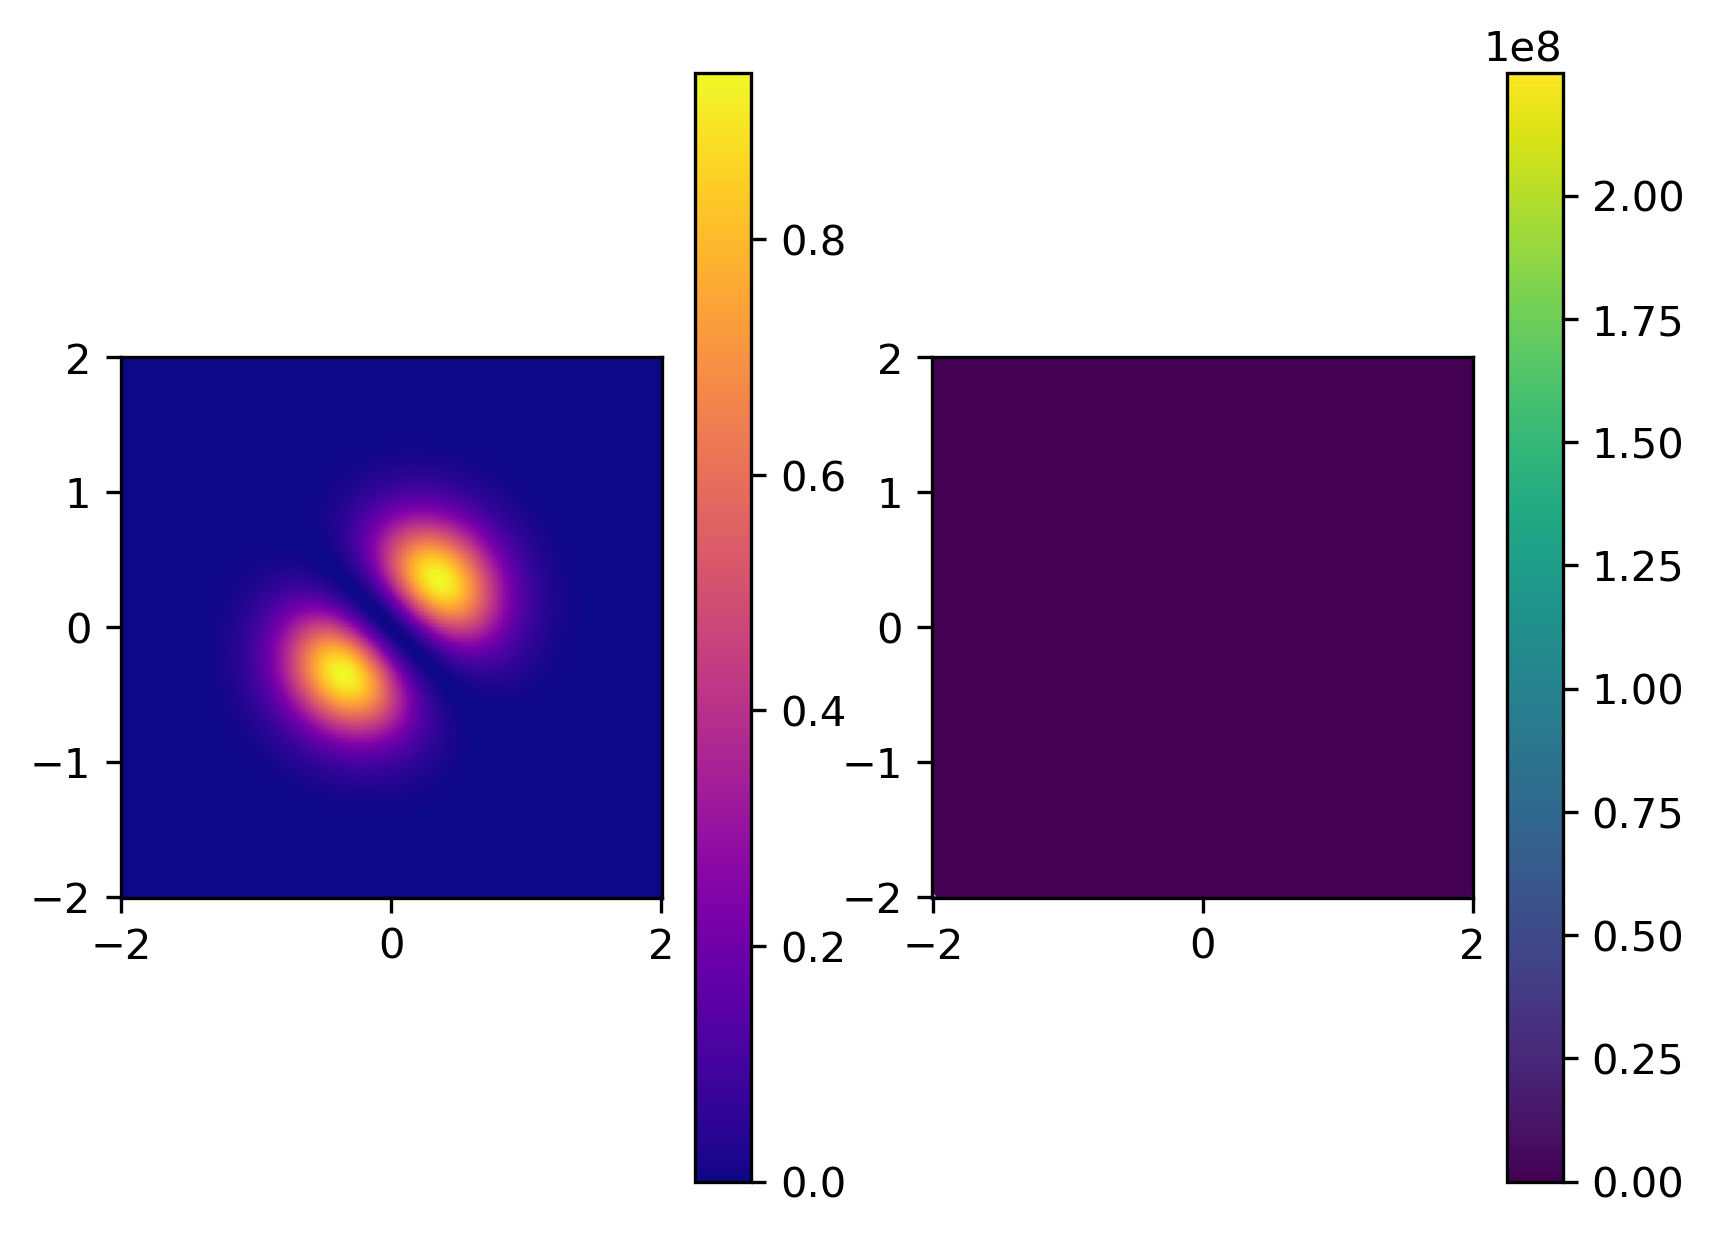

In [11]:
plt.subplot(1,2,1)
pcolor = plt.pcolormesh(splitstep.X, splitstep.Y, np.abs(all_psi[0])**2, cmap='plasma')
plt.colorbar(pcolor)
plt.gca().set_aspect('equal')

plt.subplot(1,2,2)
pcolor = plt.pcolormesh(splitstep.X, splitstep.Y, np.abs(np.fft.fft2(all_psi[0]))**2, cmap='viridis')
plt.colorbar(pcolor)
plt.gca().set_aspect('equal')

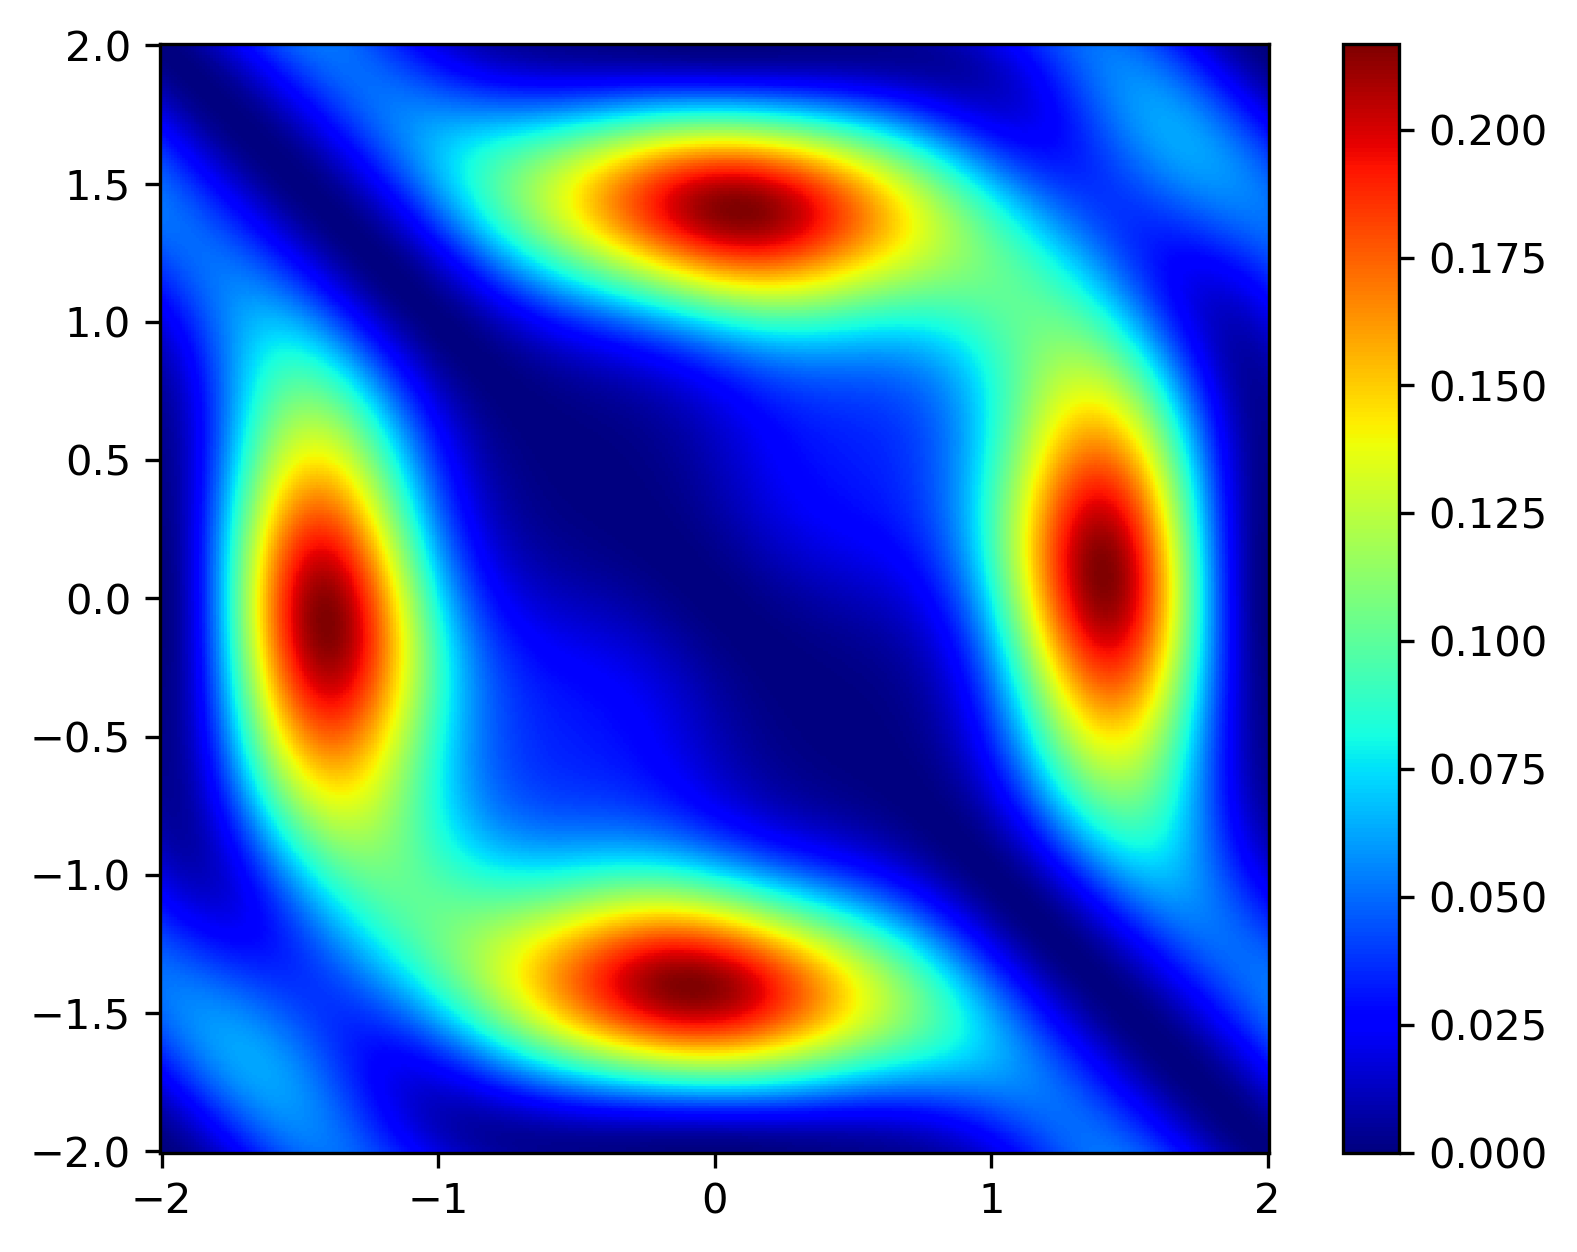

In [6]:
pcolor = plt.pcolormesh(splitstep.X, splitstep.Y, np.abs(splitstep.psi)**2, cmap='jet')
plt.colorbar(pcolor)
plt.gca().set_aspect('equal')

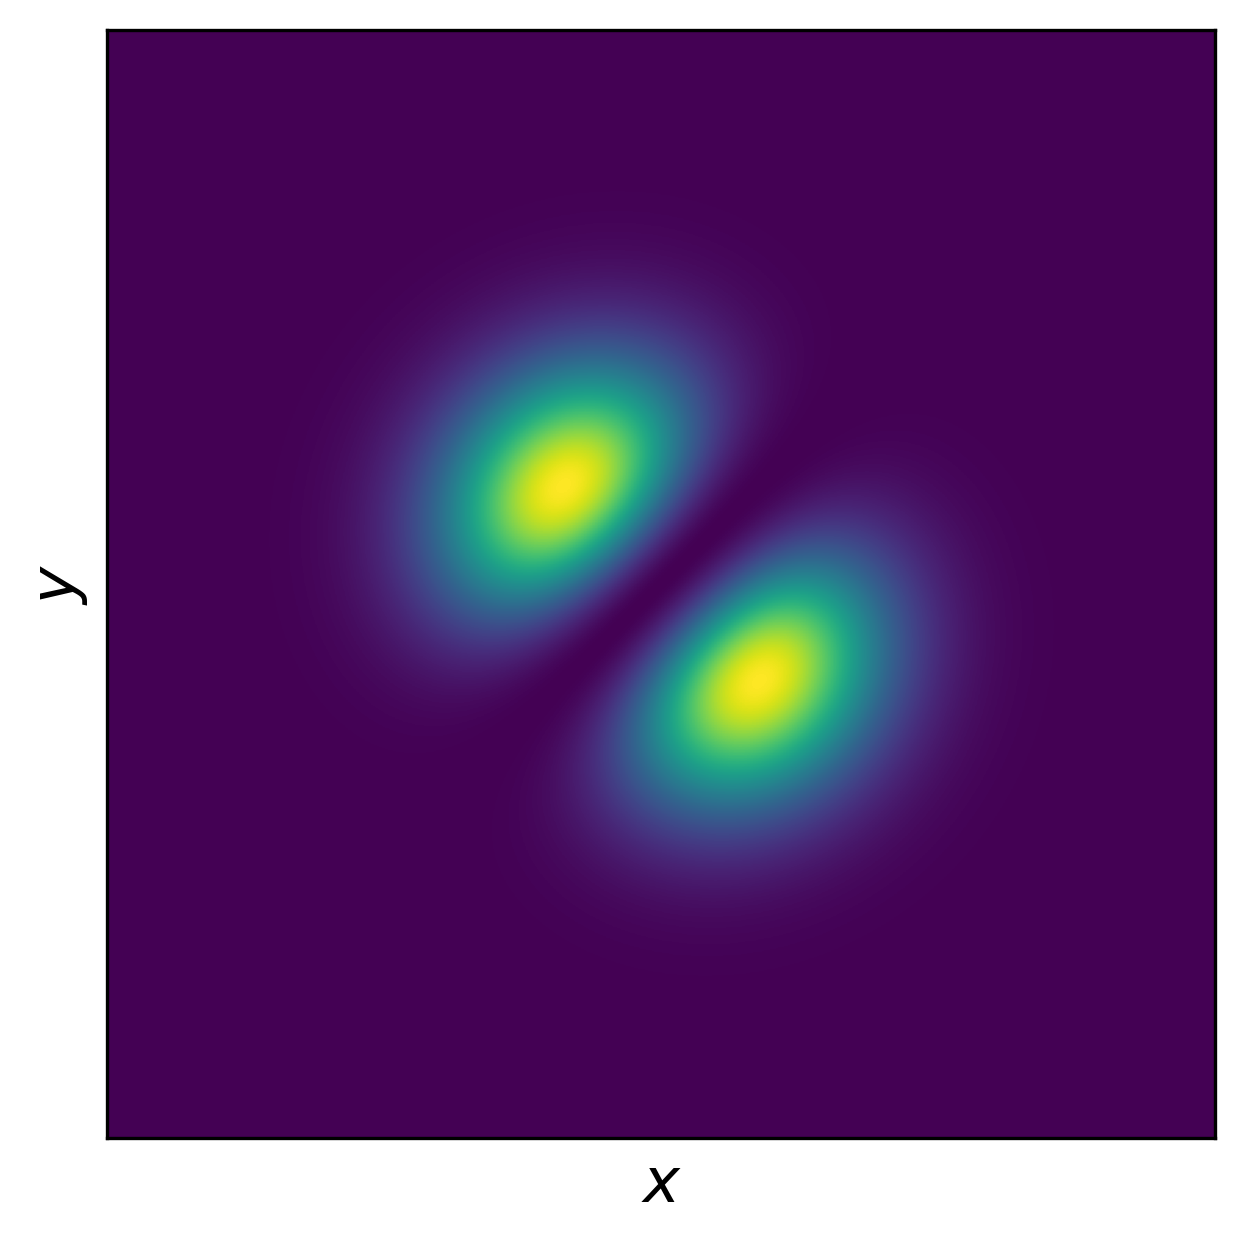

In [8]:
fig, ax = plt.subplots(figsize=(9,16))
ax.set_facecolor('black')

im = ax.imshow(np.abs(all_psi[0])**2, cmap='viridis', animated=True)

def update(frame):
    im.set_array(np.abs(all_psi[frame])**2)
    return im,

ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('$x$', fontsize=15)
ax.set_ylabel('$y$', fontsize=15)

interval = duration*1e3/nsteps
anim = animation.FuncAnimation(fig, update, frames=nsteps, interval=interval)
HTML(anim.to_html5_video())


In [8]:
splitstep.psi.shape

(400, 400)

In [9]:
np.sum(np.abs(all_psi[-1])**2*dx**2)

1.000000000000125